In [1]:
import keras
from keras.models import load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd
import cv2
base_dir = 'Selfie-dataset/images' 

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Selfie-dataset/selfie_dataset.csv')
df = df[(df.partial_faces == 0) & (df.baby == 0) & (df.child == 0)]
images = []
for i in tqdm(range(int(df['image_name'].shape[0]/2))):
    file = df['image_name'].iloc[i]
    img = cv2.imread(base_dir+'/'+file+'.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128)) / 255
    images.append(img)
images = np.array(images)

 23%|█████████████████▏                                                          | 4078/18040 [00:07<00:26, 532.95it/s]


KeyboardInterrupt: 

In [12]:
batch_size = 32
num_classes = 10
epochs = 100

In [13]:
x_train = images[:-1024]
x_test = images[1024:]

In [14]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [15]:
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

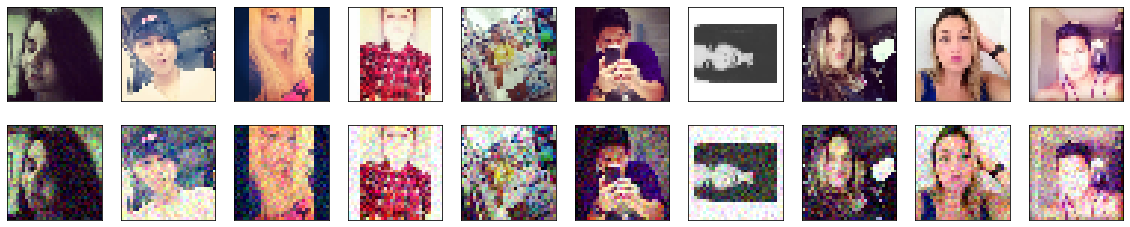

In [16]:
showOrigDec(x_train, x_train_noisy)

In [17]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')

In [19]:
model.fit(x_train_noisy, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test_noisy, x_test),
                    callbacks=[es_cb],
                    shuffle=True)

Train on 17016 samples, validate on 17016 samples
Epoch 1/100
17016/17016 [==============================] - ETA: 17:40 - loss: 0.76 - ETA: 2:14 - loss: 0.6371 - ETA: 1:12 - loss: 0.606 - ETA: 49s - loss: 0.592 - ETA: 38s - loss: 0.58 - ETA: 31s - loss: 0.57 - ETA: 26s - loss: 0.57 - ETA: 22s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5506 - ETA: 9s - loss: 0.549 - ETA: 8s - loss: 0.547 - ETA: 8s - loss: 0.547 - ETA: 7s - loss: 0.546 - ETA: 7s - loss: 0.545 - ETA: 7s - loss: 0.544 - ETA: 6s - loss: 0.543 - ETA: 6s - loss: 0.542 - ETA: 6s - loss: 0.541 - ETA: 5s - loss: 0.541 - ETA: 5s - loss: 0.540 - ETA: 5s - loss: 0.539 - ETA: 5s - loss: 0.539 - ETA: 4s - loss: 0.538 - ETA: 4s - loss: 0.537 - ETA: 4s - loss: 0.537 - ETA: 4s - loss: 0.536 - ETA: 4s - loss: 0.535 - ETA: 3s - loss: 0.535 - ETA: 3s - loss: 0.

17016/17016 [==============================] - ETA: 4s - loss: 0.486 - ETA: 3s - loss: 0.485 - ETA: 3s - loss: 0.486 - ETA: 3s - loss: 0.487 - ETA: 3s - loss: 0.487 - ETA: 3s - loss: 0.487 - ETA: 3s - loss: 0.487 - ETA: 3s - loss: 0.488 - ETA: 3s - loss: 0.488 - ETA: 3s - loss: 0.489 - ETA: 3s - loss: 0.489 - ETA: 3s - loss: 0.489 - ETA: 3s - loss: 0.489 - ETA: 3s - loss: 0.489 - ETA: 3s - loss: 0.489 - ETA: 3s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0

In [20]:
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [22]:
c10test = model.predict(x_test_noisy)

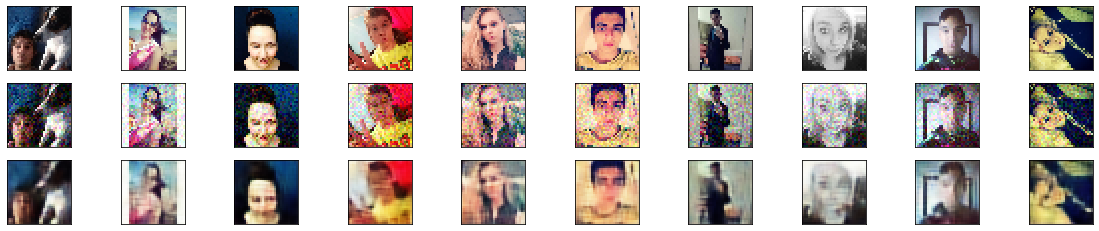

In [23]:
showOrigDec(x_test, x_test_noisy, c10test)